In [3]:
import cv2

In [4]:
import matplotlib.pyplot as plt

In [5]:
import time

import numpy as np
#from bokeh.plotting import figure
#from bokeh.io import output_notebook, show, push_notebook
#from tqdm import tqdm

#import IPython.display as Disp
#from ipywidgets import widgets

In [4]:
##### GET IMAGE FROM CAMERA #####
cap = cv2.VideoCapture(0)

if not cap.isOpened(): 
    print("Error opening video stream or file")

# Getting a first frame for the width and height of the plot
#ret, frame = cap.read()
#width, height = frame.shape[1], frame.shape[0]


for i in range(200):
    ret, frame = cap.read()
    
    if ret == True:
        cv2.imshow('frame', frame)
        #cv2.imwrite("frame%d.jpg" % i, frame)     # save frame as JPEG file
   
    if cv2.waitKey(1) & 0xFF == ord('q'): # what is that ???
        break

print(ret)
last_image = frame
cv2.imwrite("test_image.jpg", last_image)     # save frame as JPEG file

# When everything done, release the video capture object
cap.release()
      
#Destroy all the windows
cv2.destroyAllWindows()

True


In [6]:
## Read image
img_BGR = cv2.imread('test_image.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Bilateral filtering
bilateral = cv2.bilateralFilter(img,9,75,75)

# Black and white image
bw_img = cv2.cvtColor(bilateral, cv2.COLOR_RGB2GRAY)

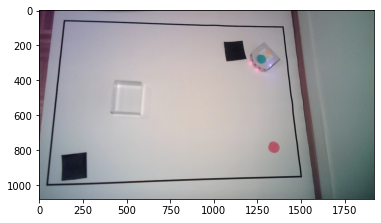

In [9]:
plt.imshow(img)

In [10]:
###### DETECTION OF THE ROBOT POSE #####

def pose_thymio(img):
    """
    Get Thymio's position (x,y) and angle w.r.t the horizontal axis 
    
    Input: RGB (planar) image of pixels
    Output: position (x,y) in pixels, angle in degrees
    """
    # HSV image
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # GREEN CIRCLE
    # create mask for green color 
    g_up = np.array([90,255,255])
    g_low = np.array([40,40,40])
    mask_green = cv2.inRange(img_hsv, g_low, g_up)
    # reduce noise
    mask_green = cv2.erode(mask_green, None, iterations = 2)
    mask_green = cv2.dilate(mask_green, None, iterations = 2)
    plt.imshow(mask_green, 'gray')
    # detect contours
    contours_green, hierarchy = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # find the position and radius of the circle
    if len(contours_green) == 1:
        (pos_green, r_green) = cv2.minEnclosingCircle(contours_green[0])
    else:
        print("Problem detecting green circle")
        # Still take the first contour, probably is the good one
        (pos_green, r_green) = cv2.minEnclosingCircle(contours_green[0])

    # BLUE CIRCLE
    # create mask for blue color
    b_up = np.array([96,255,255])
    b_low = np.array([91,50,50])
    mask_blue = cv2.inRange(img_hsv, b_low, b_up)
    # reduce noise
    mask_blue = cv2.erode(mask_blue, None, iterations = 2)
    mask_blue = cv2.dilate(mask_blue, None, iterations = 2)

    # detect contours
    contours_blue, _ = cv2.findContours(mask_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # find the position and radius of the circle
    if len(contours_blue) == 1:
        (pos_blue, r_blue) = cv2.minEnclosingCircle(contours_blue[0])
    else:
        print("Problem detecting blue circle")
        # Still take the first contour, probably is the good one
        (pos_blue, r_blue) = cv2.minEnclosingCircle(contours_blue[0])
    
    plt.plot(pos_green[0], pos_green[1], marker="o", markersize=4, markeredgecolor="red", markerfacecolor='red')
    #plt.plot(pos_blue[0], pos_blue[1], marker="o", markersize=4, markeredgecolor="red", markerfacecolor='red')
    #plt.imshow(img)

    # FIND ROBOT POSE FROM GREEN AND BLUE CIRCLES
    pos_thymio = pos_green
    delta_x = pos_blue[0] - pos_green[0]
    delta_y = pos_blue[1] - pos_green[1]
    angle_thymio = (np.arctan2(- delta_y, delta_x))*(180/np.pi) # minus for delta_y because y increases from top to bottom
    
    return pos_thymio, angle_thymio

In [11]:
##### DETECTION OF THE GOAL #####
def pos_goal(img):
    """
    Detection of the goal position

    Input: RGB (planar) image of pixels
    Output: Goal position (x,y) in planar image
    """

    # HSV image
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # RED CIRCLE DETECTION
    # create mask for red color
    r_up = np.array([190,255,255])
    r_low = np.array([170,40,40])
    mask_red = cv2.inRange(img_hsv, r_low, r_up)
    # reduce noise
    mask_red = cv2.erode(mask_red, None, iterations = 2)
    mask_red = cv2.dilate(mask_red, None, iterations = 2)

    # detect contours
    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # find the position and radius of the circle
    if len(contours_red) == 1:
        (pos_red, r_red) = cv2.minEnclosingCircle(contours_red[0])
    else:
        print("Problem detecting red circle")
        # Still take the first contour, probably is the good one
        (pos_red, r_red) = cv2.minEnclosingCircle(contours_red[0])

    plt.plot(pos_red[0], pos_red[1], marker="o", markersize=4, markeredgecolor="red", markerfacecolor='red')
    #plt.imshow(img)

    return pos_red

In [12]:
##### DETECTION OF MAP CONTOUR #####

def find_corners(img):
    """
    Finds the 4 corners of the map contour

    Input: RGB image of pixels 
    Output: corners in the order: bottom_left, bottom_right, top_left, top_right
    """
    # Threshold to get only the black shapes 
    bilateral = cv2.bilateralFilter(img,9,75,75)
    bw_img = cv2.cvtColor(bilateral, cv2.COLOR_RGB2GRAY)
    ret, th1 = cv2.threshold(bw_img, 70, 255,cv2.THRESH_BINARY)
    th1 = cv2.erode(th1, None, iterations = 4)
    th1 = cv2.dilate(th1, None, iterations = 4)

    # Detect the contours
    ext_contours, _= cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Approximate the contours to have less noise
    approx_c = []
    for c in ext_contours:
        epsilon = 0.016*cv2.arcLength(c,True)
        approx_c.append(cv2.approxPolyDP(c,epsilon,True))

    # Order the contours by area
    areas = []
    for c in approx_c:
        areas.append(cv2.contourArea(c))
    sorted_contours_ind = np.argsort(areas)
    # Map contour is the contour with the second biggest area
    map_contour_ind = sorted_contours_ind[-2]

    # Find the 4 corners of the map contour
    map_contour = approx_c[map_contour_ind]
    # Top left and bottom left corners have the smallest and biggest sum of coordinates respectively
    sum_map_corners = np.sum(map_contour, axis=2)
    top_left = map_contour[np.argmin(sum_map_corners)][0]
    bottom_right = map_contour[np.argmax(sum_map_corners)][0]
    # Top right and bottom right corners have smallest and biggest difference y-x respectively
    diff_map_corners = np.diff(map_contour, axis=2)
    top_right = map_contour[np.argmin(diff_map_corners)][0]
    bottom_left = map_contour[np.argmax(diff_map_corners)][0]

    return [bottom_left, bottom_right, top_left, top_right]

In [13]:
def resize_img(img, scale):
    """
    Size the image down to get smaller image dimensions

    Input: Image of pixels, scale = percentage of the previous image 
    Output: Resized image
    """
    # Size the image down 
    new_dim = (int(img.shape[1] * scale), int(img.shape[0] * scale))
    img_down = cv2.resize(img, new_dim, interpolation = cv2.INTER_AREA) ## check what it does exactly!!
    print("Size image scaled down: ", img_down.shape[0], img_down.shape[1])

    # Resize it up ## TO REMOVE !!
    # scale = 1 - scale
    # new_dim = (int(img_down.shape[1] * scale), int(img_down.shape[0] * scale))
    # img_up = cv2.resize(img_down, new_dim, interpolation = cv2.INTER_AREA)
    # print("Size image rescaled up: ", img_up.shape[0], img_up.shape[1])

    return img_down

In [14]:
##### TRANSFORMATION TO PLANAR #####

def img_to_planar(img, corners):
    """
    Get a top view of the image from 4 reference corner points.

    Input: RGB image of pixels, array of corner coordinates
    Output: Planar/top view image of pixels
    """
    bottom_left, bottom_right, top_left, top_right = corners[:] # Check if works fine
    
    # Compute width of grid
    bottom_width = np.sqrt((bottom_right[0] - bottom_left[0])**2 + (bottom_right[1] - bottom_left[1])**2)
    top_width = np.sqrt((top_right[0] - top_left[0])**2 + (top_right[1] - top_left[1])**2)
    width = int(np.max([bottom_width, top_width]))

    # Compute length of grid 
    left_length = np.sqrt((bottom_left[0] - top_left[0])**2 + (bottom_left[1] - top_left[1])**2)
    right_length = np.sqrt((bottom_right[0] - top_right[0])**2 + (bottom_right[1] - top_right[1])**2)
    length = int(np.max([left_length, right_length]))

    # Conversion to planar view
    source_corners = np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.float32)
    output_corners = np.array([[0,length], [width,length], [0,0], [width,0]], dtype=np.float32)

    transformation = cv2.getPerspectiveTransform(source_corners, output_corners)
    planar_img = cv2.warpPerspective(img, transformation, (width, length))

    return planar_img


In [15]:
##### FUNCTION USED FOR GLOBAL NAVIGATION #####
##### DETECTION OF OBSTACLES --> TRANSFORMATION TO OCCUPANCY GRID #####

def img_to_occupancy_grid(img, scale):
    """
    Transform the image into a smaller size occupancy grid
    
    Input:  RGB image of pixels, scale by which we want to reduce the size of the image (need a quite small grid for 
            global navigation)
    Output: Binary grid of 1 and 0, position of the robot, angle of the robot in the grid frame, position of the goal
    """
    # Transform to planar image
    corners = find_corners(img)
    planar_img = img_to_planar(img, corners)

    # Bilateral filtering
    bilateral = cv2.bilateralFilter(planar_img,9,75,75)

    # Binary image
    bw_img = cv2.cvtColor(bilateral, cv2.COLOR_RGB2GRAY)

    # Threshold to keep only the obstacles
    ret, obstacles_img = cv2.threshold(bw_img, 70, 255,cv2.THRESH_BINARY)
    
    # Resize the image
    obstacles_img = resize_img(obstacles_img, scale)
    
    # Remove noise  ## CHECK IF NECESSARY !! (FOR SMALL BLACK SENSORS ON THYMIO)
    obstacles_img = cv2.medianBlur(obstacles_img, ksize=1)
     
    # Find position of the Thymio 
    pos_thymio, angle_thymio = pose_thymio(planar_img)
    # Rescale Thymio's pose 
    pos_thymio = (int(pos_thymio[0]*scale), int(pos_thymio[1]*scale))
    print(pos_thymio, angle_thymio)

    # Find position of the goal and rescale it 
    goal = pos_goal(planar_img)
    goal = (int(goal[0])*scale, int(goal[1]*scale))

    # Transform into grid of 0 (black) and 1 (white)
    grid = np.array(obstacles_img)
    grid[grid != 0] = 1
    #plt.imshow(grid, 'gray')

    ## TO REMOVE !
    #plt.plot(goal[0], goal[1], marker="o", markersize=4, markeredgecolor="red", markerfacecolor='red')
    #plt.plot(pos_thymio[0], pos_thymio[1], marker="o", markersize=4, markeredgecolor="red", markerfacecolor='red')
    #plt.imshow(grid,'gray')

    return grid, pos_thymio, angle_thymio, goal

In [33]:
def picture(cap):
    for i in range(4):
        ret, picture = cap.read()
        if ret == False:
            print("Camera not reading")
        time.sleep(2) # wait 2 seconds --> necessary ????
    return picture # returns the last picture which should be focused 

In [34]:
def print_traj(img, pos_thymio, list_pos_thymio):
    x,y = pos_thymio
    list_pos_thymio.append((int(x),int(y))) #pos_thym = [x,y]
    
    for i in range(list_pos_thymio):
        x,y = list_pos_thymio[i]
        cv2.circle(img,(int(x),int(y)), 3, (0,0,0), 2)

Size image scaled down:  94 146
Problem detecting green circle


IndexError: tuple index out of range

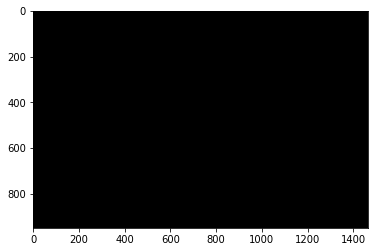

In [16]:
grid,pos,angle,goal = img_to_occupancy_grid(img, scale=0.1)
#plt.imshow(grid,'gray')

Problem detecting red circle
(1308, 779)


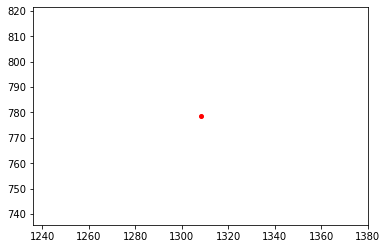

In [21]:
corners = find_corners(img)
planar_img = img_to_planar(img, corners)
goal = pos_goal(planar_img)
print((round(goal[0]), round(goal[1])))

In [54]:
# Find RGB value in HSV
color = np.uint8([[[255,100,100]]])
hsv_color = cv2.cvtColor(color,cv2.COLOR_BGR2HSV)

print(hsv_color)
# then do [H-10,100,100] [H+10,255,255]

[[[120 155 255]]]


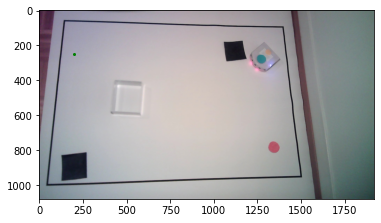

In [11]:
def plot_point(point, color="red", size=2):
        plt.plot(point[0], point[1], marker="o", markersize=size, markeredgecolor=color, markerfacecolor=color)

def print_init(img_to_print):
    plot_point([200,250], "green")
    plt.imshow(img_to_print)

print_init(img)

In [1]:
# Former color ranges
# Y_UP = np.array([50, 255, 255])
# Y_LOW = np.array([0, 40, 40])
# B_UP = np.array([100, 255, 255])
# B_LOW = np.array([91, 40, 40])ƒ

In [2]:
import Vision
print(Vision.variable)

AttributeError: module 'Vision' has no attribute 'variable'